In [1]:
import os
import sys
import pickle
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms

from PIL import Image

from model import MyModel
from utils import score, load_checkpoint, reset, count_parameters

In [2]:
import random
def manual_seed(seed):
    np.random.seed(seed) #1
    random.seed(seed) #2
    torch.manual_seed(seed) #3
    torch.cuda.manual_seed(seed) #4.1
    torch.cuda.manual_seed_all(seed) #4.2
    torch.backends.cudnn.benchmark = False #5 
    torch.backends.cudnn.deterministic = True #6

In [3]:
train_data_fp = 'train.npz'
val_data_fp = 'val.npz'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 64
print(os.getcwd())
print(device)

/workspace/ai-toolkit
cuda


In [4]:
manual_seed(40)

In [5]:
from collections import Counter
with np.load(train_data_fp, allow_pickle=True) as data:
    train_imgs = data["data"]
    train_labels = data["labels"]
    print(Counter(train_labels))

print(f"train data :{len(train_labels)}")

with np.load(val_data_fp, allow_pickle=True) as data:
    val_imgs = data["data"]
    val_labels = data["labels"]
    print(Counter(val_labels))

print(f"val data :{len(val_labels)}")


class FMnistDataset(Dataset):
    def __init__(self, npz_fp, transform=None):
        with np.load(npz_fp, allow_pickle=True) as data:
            self.data = data["data"]
            self.labels = data["labels"]
        self.transform = transform

        shuffle_index = np.arange(len(self.labels))
        np.random.shuffle(shuffle_index)
        self.data = self.data[shuffle_index]
        self.labels = self.labels[shuffle_index]

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int):
        img_data = self.data[idx].astype("uint8").reshape((28, 28))
        img_label = int(self.labels[idx])

        img_data = Image.fromarray(img_data)

        if self.transform:
            img_data = self.transform(img_data)

        return img_data, img_label
    

train_transforms = transforms.Compose(
    [
        transforms.RandomApply([

            transforms.RandomAutocontrast(),
            transforms.RandomRotation(30),
            # transforms.RandomHorizontalFlip(),
            # transforms.RandomAutocontrast(),
            transforms.GaussianBlur(3),
            transforms.RandomResizedCrop((28,28),(0.8,0.8)),
        ], p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.286], std=[0.353]),
        transforms.RandomErasing(scale=(0.02,0.2))
    ]
)

train_dataset = FMnistDataset(train_data_fp, transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, persistent_workers=True, pin_memory=True)

val_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.286], std=[0.353]),
    ]
)

val_dataset = FMnistDataset(val_data_fp, transform=val_transforms)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8, persistent_workers=True, pin_memory=True)
print(len(train_dataset), len(val_dataset))


Counter({4: 4200, 2: 4200, 9: 4200, 5: 4200, 1: 4200, 0: 4200, 8: 4200, 3: 4200, 7: 4200, 6: 4200})
train data :42000
Counter({3: 1400, 7: 1400, 5: 1400, 1: 1400, 8: 1400, 2: 1400, 4: 1400, 9: 1400, 6: 1400, 0: 1400})
val data :14000
42000 14000


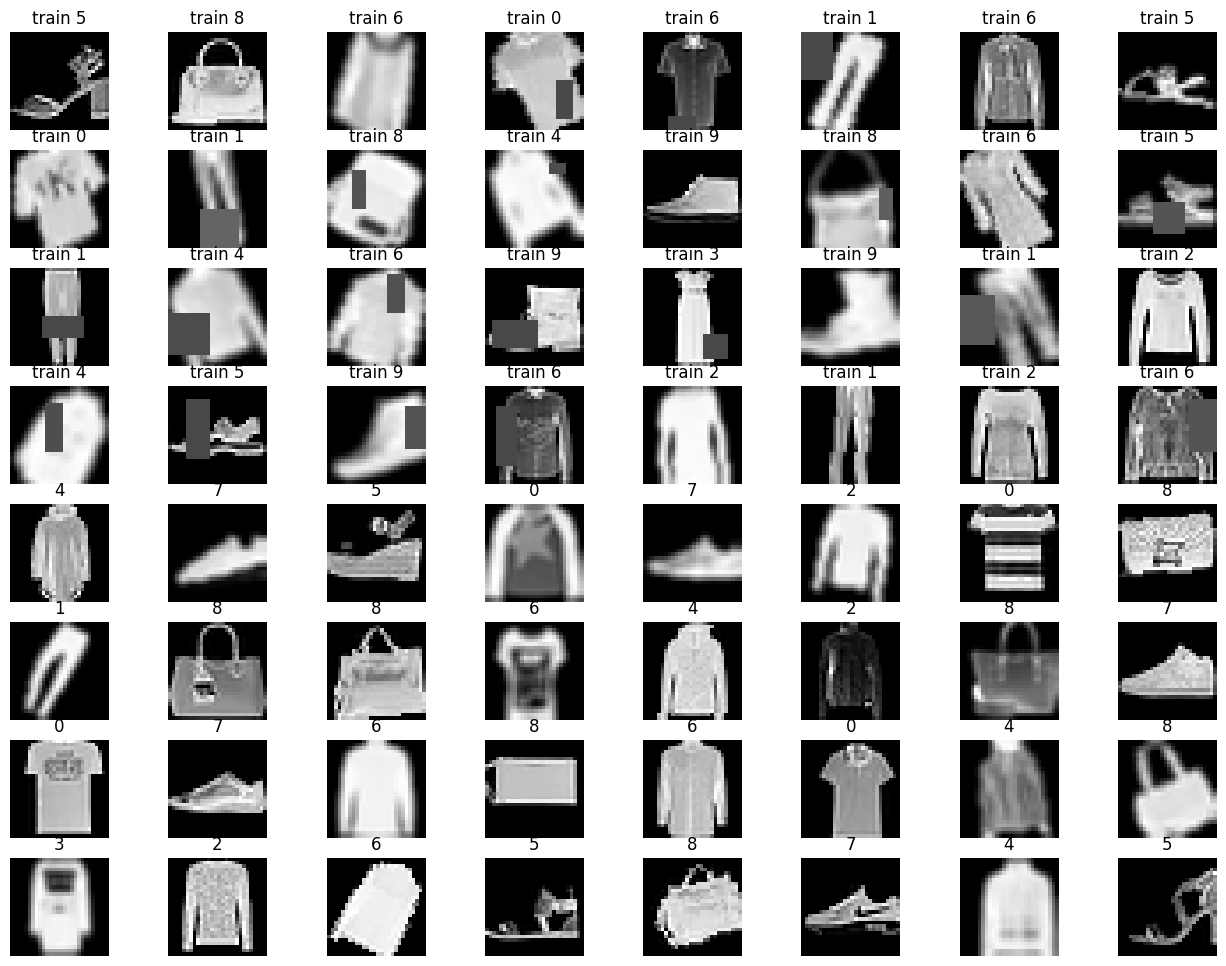

In [6]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import normalize
plt.figure(figsize=(16,12))
sample_img, sample_label = next(iter(train_loader))

for i in range(32):
    plt.subplot(8,8,i+1)
    mean = np.array(0.286)
    std = np.array(0.353)
    plt_img = (sample_img[i] *std + mean)*255
    plt_img = np.array(plt_img, dtype=np.uint8).squeeze(0)
    plt.title(f"train {sample_label[i]}")
    plt.axis('off')
    plt.imshow(plt_img,cmap='gray')

sample_img, sample_label = next(iter(val_loader))

for i in range(32):
    plt.subplot(8,8,i+1+32)
    mean = np.array(0.286)
    std = np.array(0.353)
    plt_img = (sample_img[i] *std + mean)*255
    plt_img = np.array(plt_img, dtype=np.uint8).squeeze(0)
    plt.title(f"{sample_label[i]}")
    plt.axis('off')
    plt.imshow(plt_img,cmap='gray')

    

In [7]:
# all_imgs = np.concatenate([train_imgs,val_imgs],axis=0)
# all_labels = np.concatenate([train_labels, val_labels], axis=0)
# shuffle_index = np.arange(len(all_labels))
# np.random.shuffle(shuffle_index)
# all_imgs = all_imgs[shuffle_index]
# all_labels = all_labels[shuffle_index]


# print(f"after random shuffle")
# split_num = 42000
# train_imgs = all_imgs[:split_num]
# train_labels = all_labels[:split_num]
# val_imgs = all_imgs[split_num:]
# val_labels = all_labels[split_num:]

# print(Counter(train_labels))
# print(Counter(val_labels))

# class FDataset(Dataset):
#     def __init__(self, imgs, labels, transform = None):
#         self.imgs = imgs
#         self.labels = labels
#         self.transform = transform
    
#     def __len__(self) -> int:
#         return len(self.labels)

#     def __getitem__(self, idx: int):
#         img_data = self.imgs[idx].astype("uint8").reshape((28, 28))
#         img_label = int(self.labels[idx])

#         img_data = Image.fromarray(img_data)

#         if self.transform:
#             img_data = self.transform(img_data)

#         return img_data, img_label


# train_transforms = transforms.Compose(
#     [
#         transforms.ColorJitter(0,0.2,0),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.286], std=[0.353]),
#     ]
# )

# train_dataset = FDataset(train_imgs, train_labels, transform=train_transforms)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, persistent_workers=True, pin_memory=True)

# val_transforms = transforms.Compose(
#     [
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.286], std=[0.353]),
#     ]
# )

# val_dataset = FDataset(val_imgs, val_labels, transform=val_transforms)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8, persistent_workers=True, pin_memory=True)
# print(f"Dataloader train :{len(train_dataset), len(val_dataset)}")

In [8]:
LR = 5e-4
EPOCHS= 100

In [9]:
!pip install tqdm

In [10]:
model = MyModel()
print(count_parameters(model))
optimizer = torch.optim.RAdam(model.parameters(), lr = LR,  weight_decay=0.005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',factor=0.5,patience=5)
# scheduler = None
criterion = torch.nn.CrossEntropyLoss()

935562


In [11]:
from tqdm.auto import tqdm

scaler = torch.cuda.amp.GradScaler(enabled=True)

model.to(device)
best_acc = 0
for epoch in range(EPOCHS):
    running_loss = 0
    running_acc = 0
    model.train()
    train_loader = tqdm(train_loader, leave=False)

    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        with torch.autocast(device_type=device, dtype=torch.float16, enabled=True):
            outputs = model(imgs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        # loss.backward()
        # optimizer.step()

        preds = torch.argmax(outputs, dim=-1)
        running_loss += loss.item()
        running_acc += (preds==labels).sum().item()
    running_acc = running_acc /len(train_dataset)*100
    print(f"{epoch+1} training_loss : {running_loss /len(train_loader):.2f} acc :{running_acc:.2f}%, lr = {optimizer.param_groups[0]['lr']}")

    # val
    model.eval()
    val_loss = 0
    val_acc = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, dim=-1)

            val_loss += loss.item()
            val_acc += (preds==labels).sum().item()
    val_acc = val_acc/ len(val_dataset)*100
    print(f"\tval_loss : {val_loss /len(val_loader):.2f} acc :{val_acc:.2f}%")
    if best_acc < val_acc:
        best_acc = val_acc
        checkpoint = {
            'model' : MyModel(),
            'model_state_dict' : model.state_dict(),
        }
        torch.save(checkpoint, './check/checkpoint.pth')
        print(f"save best acc {best_acc:.2f}")

    if scheduler:
        scheduler.step(val_loss)


/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1 training_loss : 1.04 acc :65.15%, lr = 0.0005
	val_loss : 0.76 acc :72.13%
save best acc 72.13


2 training_loss : 0.59 acc :78.92%, lr = 0.0005
	val_loss : 0.63 acc :78.00%
save best acc 78.00


3 training_loss : 0.52 acc :81.48%, lr = 0.0005
	val_loss : 0.57 acc :79.36%
save best acc 79.36


4 training_loss : 0.49 acc :82.68%, lr = 0.0005
	val_loss : 0.50 acc :83.04%
save best acc 83.04


5 training_loss : 0.47 acc :83.68%, lr = 0.0005
	val_loss : 0.73 acc :73.91%


6 training_loss : 0.45 acc :84.25%, lr = 0.0005
	val_loss : 0.49 acc :82.76%


7 training_loss : 0.44 acc :84.61%, lr = 0.0005
	val_loss : 0.56 acc :79.79%


8 training_loss : 0.43 acc :85.06%, lr = 0.0005
	val_loss : 0.49 acc :83.26%
save best acc 83.26


9 training_loss : 0.42 acc :85.58%, lr = 0.0005
	val_loss : 0.50 acc :82.54%


10 training_loss : 0.41 acc :85.82%, lr = 0.0005
	val_loss : 0.41 acc :85.49%
save best acc 85.49


11 training_loss : 0.40 acc :86.11%, lr = 0.0005
	val_loss : 0.42 acc :85.68%
save best acc 85.68


12 training_loss : 0.40 acc :86.28%, lr = 0.0005
	val_loss : 0.37 acc :86.85%
save best acc 86.85


13 training_loss : 0.39 acc :86.51%, lr = 0.0005
	val_loss : 0.40 acc :85.77%


14 training_loss : 0.39 acc :86.51%, lr = 0.0005
	val_loss : 0.40 acc :85.99%


15 training_loss : 0.38 acc :86.84%, lr = 0.0005
	val_loss : 0.40 acc :86.83%


16 training_loss : 0.37 acc :87.11%, lr = 0.0005
	val_loss : 0.40 acc :85.84%


17 training_loss : 0.37 acc :86.93%, lr = 0.0005
	val_loss : 0.36 acc :87.16%
save best acc 87.16


18 training_loss : 0.37 acc :87.31%, lr = 0.0005
	val_loss : 0.37 acc :87.11%


19 training_loss : 0.37 acc :87.26%, lr = 0.0005
	val_loss : 0.39 acc :85.92%


20 training_loss : 0.37 acc :87.31%, lr = 0.0005
	val_loss : 0.37 acc :86.67%


21 training_loss : 0.37 acc :87.24%, lr = 0.0005
	val_loss : 0.40 acc :85.74%


22 training_loss : 0.37 acc :87.41%, lr = 0.0005
	val_loss : 0.37 acc :86.94%


23 training_loss : 0.36 acc :87.37%, lr = 0.0005
	val_loss : 0.37 acc :87.00%


24 training_loss : 0.33 acc :88.64%, lr = 0.00025
	val_loss : 0.35 acc :87.82%
save best acc 87.82


25 training_loss : 0.32 acc :88.86%, lr = 0.00025
	val_loss : 0.32 acc :88.62%
save best acc 88.62


26 training_loss : 0.32 acc :89.04%, lr = 0.00025
	val_loss : 0.34 acc :88.01%


27 training_loss : 0.32 acc :89.21%, lr = 0.00025
	val_loss : 0.35 acc :87.81%


28 training_loss : 0.32 acc :89.19%, lr = 0.00025
	val_loss : 0.34 acc :87.98%


29 training_loss : 0.31 acc :89.51%, lr = 0.00025
	val_loss : 0.35 acc :87.82%


30 training_loss : 0.31 acc :89.50%, lr = 0.00025
	val_loss : 0.34 acc :87.99%


31 training_loss : 0.31 acc :89.36%, lr = 0.00025
	val_loss : 0.34 acc :88.33%


32 training_loss : 0.29 acc :90.22%, lr = 0.000125
	val_loss : 0.31 acc :88.83%
save best acc 88.83


33 training_loss : 0.28 acc :90.56%, lr = 0.000125
	val_loss : 0.30 acc :88.96%
save best acc 88.96


34 training_loss : 0.28 acc :90.42%, lr = 0.000125
	val_loss : 0.30 acc :89.20%
save best acc 89.20


35 training_loss : 0.28 acc :90.66%, lr = 0.000125
	val_loss : 0.30 acc :89.54%
save best acc 89.54


36 training_loss : 0.28 acc :90.65%, lr = 0.000125
	val_loss : 0.31 acc :89.16%


37 training_loss : 0.28 acc :90.71%, lr = 0.000125
	val_loss : 0.31 acc :89.48%


38 training_loss : 0.28 acc :90.76%, lr = 0.000125
	val_loss : 0.30 acc :89.40%


39 training_loss : 0.27 acc :90.70%, lr = 0.000125
	val_loss : 0.31 acc :88.99%


40 training_loss : 0.27 acc :90.97%, lr = 0.000125
	val_loss : 0.30 acc :89.51%


41 training_loss : 0.27 acc :90.95%, lr = 0.000125
	val_loss : 0.31 acc :89.39%


42 training_loss : 0.26 acc :91.47%, lr = 6.25e-05
	val_loss : 0.29 acc :89.68%
save best acc 89.68


43 training_loss : 0.25 acc :91.80%, lr = 6.25e-05
	val_loss : 0.29 acc :89.79%
save best acc 89.79


44 training_loss : 0.25 acc :91.69%, lr = 6.25e-05
	val_loss : 0.29 acc :89.95%
save best acc 89.95


45 training_loss : 0.25 acc :91.79%, lr = 6.25e-05
	val_loss : 0.29 acc :89.74%


46 training_loss : 0.25 acc :91.92%, lr = 6.25e-05
	val_loss : 0.29 acc :89.91%


47 training_loss : 0.24 acc :92.13%, lr = 6.25e-05
	val_loss : 0.29 acc :89.88%


48 training_loss : 0.25 acc :92.09%, lr = 6.25e-05
	val_loss : 0.29 acc :90.04%
save best acc 90.04


49 training_loss : 0.24 acc :92.07%, lr = 6.25e-05
	val_loss : 0.29 acc :89.79%


50 training_loss : 0.25 acc :91.94%, lr = 6.25e-05
	val_loss : 0.29 acc :89.55%


51 training_loss : 0.25 acc :91.92%, lr = 6.25e-05
	val_loss : 0.29 acc :89.77%


52 training_loss : 0.24 acc :92.16%, lr = 6.25e-05
	val_loss : 0.29 acc :89.95%


53 training_loss : 0.24 acc :92.22%, lr = 6.25e-05
	val_loss : 0.29 acc :90.00%


54 training_loss : 0.24 acc :92.05%, lr = 6.25e-05
	val_loss : 0.28 acc :90.32%
save best acc 90.32


55 training_loss : 0.24 acc :92.10%, lr = 6.25e-05
	val_loss : 0.28 acc :90.26%


56 training_loss : 0.24 acc :92.35%, lr = 6.25e-05
	val_loss : 0.29 acc :89.84%


57 training_loss : 0.24 acc :92.12%, lr = 6.25e-05
	val_loss : 0.29 acc :89.68%


58 training_loss : 0.24 acc :92.02%, lr = 6.25e-05
	val_loss : 0.29 acc :89.83%


59 training_loss : 0.24 acc :92.34%, lr = 6.25e-05
	val_loss : 0.28 acc :90.04%


60 training_loss : 0.24 acc :92.23%, lr = 6.25e-05
	val_loss : 0.29 acc :89.77%


61 training_loss : 0.24 acc :92.32%, lr = 6.25e-05
	val_loss : 0.29 acc :89.80%


62 training_loss : 0.23 acc :92.62%, lr = 3.125e-05
	val_loss : 0.29 acc :89.94%


63 training_loss : 0.23 acc :92.70%, lr = 3.125e-05
	val_loss : 0.28 acc :89.89%


64 training_loss : 0.23 acc :92.90%, lr = 3.125e-05
	val_loss : 0.28 acc :90.26%


65 training_loss : 0.22 acc :93.01%, lr = 3.125e-05
	val_loss : 0.29 acc :90.09%


66 training_loss : 0.22 acc :92.80%, lr = 3.125e-05
	val_loss : 0.29 acc :90.11%


67 training_loss : 0.22 acc :92.81%, lr = 3.125e-05
	val_loss : 0.28 acc :90.06%


68 training_loss : 0.22 acc :93.14%, lr = 1.5625e-05
	val_loss : 0.27 acc :90.41%
save best acc 90.41


69 training_loss : 0.22 acc :93.23%, lr = 1.5625e-05
	val_loss : 0.28 acc :90.27%


70 training_loss : 0.22 acc :92.99%, lr = 1.5625e-05
	val_loss : 0.27 acc :90.54%
save best acc 90.54


71 training_loss : 0.21 acc :93.34%, lr = 1.5625e-05
	val_loss : 0.28 acc :90.21%


72 training_loss : 0.21 acc :93.40%, lr = 1.5625e-05
	val_loss : 0.28 acc :90.44%


73 training_loss : 0.21 acc :93.25%, lr = 1.5625e-05
	val_loss : 0.28 acc :90.32%


74 training_loss : 0.21 acc :93.52%, lr = 1.5625e-05
	val_loss : 0.28 acc :90.51%


75 training_loss : 0.22 acc :93.10%, lr = 1.5625e-05
	val_loss : 0.28 acc :90.29%


76 training_loss : 0.21 acc :93.28%, lr = 1.5625e-05
	val_loss : 0.27 acc :90.59%
save best acc 90.59


77 training_loss : 0.21 acc :93.40%, lr = 1.5625e-05
	val_loss : 0.28 acc :90.34%


78 training_loss : 0.21 acc :93.24%, lr = 1.5625e-05
	val_loss : 0.28 acc :90.20%


79 training_loss : 0.21 acc :93.37%, lr = 1.5625e-05
	val_loss : 0.28 acc :90.21%


80 training_loss : 0.21 acc :93.42%, lr = 1.5625e-05
	val_loss : 0.28 acc :90.34%


81 training_loss : 0.21 acc :93.24%, lr = 1.5625e-05
	val_loss : 0.28 acc :90.56%


82 training_loss : 0.21 acc :93.30%, lr = 1.5625e-05
	val_loss : 0.28 acc :90.28%


83 training_loss : 0.21 acc :93.33%, lr = 7.8125e-06
	val_loss : 0.28 acc :90.34%


84 training_loss : 0.21 acc :93.23%, lr = 7.8125e-06
	val_loss : 0.27 acc :90.66%
save best acc 90.66


85 training_loss : 0.21 acc :93.64%, lr = 7.8125e-06
	val_loss : 0.28 acc :90.29%


86 training_loss : 0.21 acc :93.44%, lr = 7.8125e-06
	val_loss : 0.27 acc :90.50%


87 training_loss : 0.21 acc :93.46%, lr = 7.8125e-06
	val_loss : 0.28 acc :90.30%


88 training_loss : 0.21 acc :93.39%, lr = 7.8125e-06
	val_loss : 0.28 acc :90.52%


89 training_loss : 0.20 acc :93.63%, lr = 7.8125e-06
	val_loss : 0.28 acc :90.41%


90 training_loss : 0.21 acc :93.42%, lr = 7.8125e-06
	val_loss : 0.28 acc :90.31%


91 training_loss : 0.21 acc :93.59%, lr = 7.8125e-06
	val_loss : 0.28 acc :90.37%


92 training_loss : 0.21 acc :93.64%, lr = 7.8125e-06
	val_loss : 0.28 acc :90.35%


93 training_loss : 0.21 acc :93.54%, lr = 3.90625e-06
	val_loss : 0.28 acc :90.27%


94 training_loss : 0.20 acc :93.70%, lr = 3.90625e-06
	val_loss : 0.27 acc :90.39%


95 training_loss : 0.21 acc :93.64%, lr = 3.90625e-06
	val_loss : 0.28 acc :90.20%


96 training_loss : 0.20 acc :93.60%, lr = 3.90625e-06
	val_loss : 0.28 acc :90.36%


97 training_loss : 0.21 acc :93.59%, lr = 3.90625e-06
	val_loss : 0.28 acc :90.41%


98 training_loss : 0.20 acc :93.62%, lr = 3.90625e-06
	val_loss : 0.28 acc :90.16%


99 training_loss : 0.20 acc :93.77%, lr = 1.953125e-06
	val_loss : 0.27 acc :90.24%


100 training_loss : 0.20 acc :93.72%, lr = 1.953125e-06
	val_loss : 0.27 acc :90.59%
